# Yelp Sentiment Analysis with doc2vec Document Vectors

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/packt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pathlib import Path
import logging
from random import shuffle

import numpy as np
import pandas as pd

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from nltk import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### Settings

In [4]:
sns.set_style('white')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Paths

In [5]:
data_path = Path('..', 'data', 'yelp')

In [6]:
results_path = Path('results', 'yelp')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Logging Config

In [7]:
logging.basicConfig(
        filename=results_path / 'doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

Refer to download information [here](../data/create_yelp_review_data.ipynb).

We'll create a smaller sample of 100,000 reviews per star rating.

In [8]:
sample = pd.read_parquet(results_path / 'review_sample.parquet').reset_index(drop=True)

In [9]:
sample.head()

,stars,text
0,1.0,I have worked with Peter at Green Arrow for a...
1,1.0,Worst salon ever!!!! They make an appointment ...
2,1.0,could be happenin' if anybody showed up. pitt...
3,1.0,"Yeah, so nothing has changed with their servic..."
4,1.0,I sent a parts request through their online em...


In [10]:
stars = range(1, 6)

## Doc2Vec

### Basic text cleaning

In [11]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def clean(review):
    tokens = tokenizer.tokenize(review)
    return ' '.join([t for t in tokens if t not in stopword_set])

In [12]:
sample.text = sample.text.str.lower().apply(clean)

In [13]:
sample.sample(n=10)

,stars,text
104241,2.0,really bad experience yesterday night buffet i...
199676,2.0,everything place ok nothing special nothing cr...
140199,2.0,expected hardly flavor food accommodating vege...
132814,2.0,consultant helped us seem happy pull number dr...
408697,5.0,stopped late lunch food prepared quick service...
163280,2.0,middle aged dude wants enjoy cold brew ogle wa...
215758,3.0,expensive get food pretty good pizzas good bre...
442316,5.0,ordered delivery got fast 30 minutes order win...
6940,1.0,could see plate sitting kitchen took several m...
382310,4.0,stayed first time past weekend went vegas whim...


In [14]:
sample = sample[sample.text.str.split().str.len()>10]
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485725 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   485725 non-null  float64
 1   text    485725 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.1+ MB


### Create sentence stream

In [15]:
sentences = []
for i, (_, text) in enumerate(sample.values):
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

### Formulate the model

In [16]:
model = Doc2Vec(documents=sentences,
                dm=1,           # 1=distributed memory, 0=dist.BOW
                epochs=5,
                size=300,       # vector size
                window=5,       # max. distance betw. target and context
                min_count=50,   # ignore tokens w. lower frequency
                negative=5,     # negative training samples
                dm_concat=0,    # 1=concatenate vectors, 0=sum
                dbow_words=0,   # 1=train word vectors as well
                workers=4)

In [17]:
pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])

,token,similarity
0,great,0.771758
1,decent,0.750678
2,awesome,0.643779
3,amazing,0.618799
4,bad,0.618504
5,excellent,0.599835
6,yummy,0.598594
7,ok,0.594872
8,okay,0.593302
9,tasty,0.591461


### Continue training

In [18]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [19]:
most_similar = pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])
most_similar

,token,similarity
0,great,0.749972
1,decent,0.719081
2,awesome,0.619438
3,amazing,0.610857
4,excellent,0.609045
5,fantastic,0.586726
6,tasty,0.555088
7,ok,0.540861
8,yummy,0.539665
9,delicious,0.533906


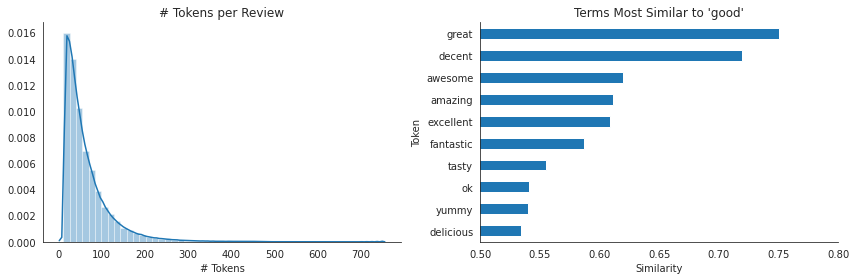

In [20]:
fig, axes =plt.subplots(ncols=2, figsize=(12, 4))
sns.distplot(sample.text.str.split().str.len(), ax=axes[0])
axes[0].set_title('# Tokens per Review')

most_similar.set_index('token').similarity.sort_values().plot.barh(ax=axes[1], 
                                                                   title="Terms Most Similar to 'good'",
                                                                  xlim=(.5, .8))
axes[1].set_xlabel('Similarity')
axes[1].set_ylabel('Token')
axes[0].set_xlabel('# Tokens')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'doc2vec_stats', dpi=300)

## Persist Model

In [21]:
model.save((results_path / 'sample.model').as_posix())

In [ ]:
model = Doc2Vec.load((results_path / 'sample.model').as_posix())

## Evaluate

In [22]:
y = sample.stars.sub(1)

In [23]:
size = 300
X = np.zeros(shape=(len(y), size))
for i in range(len(sample)):
    X[i] = model.docvecs[i]

In [24]:
X.shape

(485725, 300)

### Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [26]:
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 20.15%


In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [28]:
class_weights

array([0.99618017, 0.9923514 , 0.99524889, 1.00219225, 1.01433084])

## LightGBM

In [29]:
train_data = lgb.Dataset(data=X_train, label=y_train)
test_data = train_data.create_valid(X_test, label=y_test)

In [30]:
params = {'objective': 'multiclass',
          'num_classes': 5}

In [31]:
lgb_model = lgb.train(params=params,
                      train_set=train_data,
                      num_boost_round=5000,
                      valid_sets=[train_data, test_data],
                      early_stopping_rounds=25,
                      verbose_eval=50)

Training until validation scores don't improve for 25 rounds
[50]	training's multi_logloss: 1.4421	valid_1's multi_logloss: 1.46101
[100]	training's multi_logloss: 1.38415	valid_1's multi_logloss: 1.41855
[150]	training's multi_logloss: 1.33987	valid_1's multi_logloss: 1.38853
[200]	training's multi_logloss: 1.30264	valid_1's multi_logloss: 1.36496
[250]	training's multi_logloss: 1.27066	valid_1's multi_logloss: 1.34629
[300]	training's multi_logloss: 1.24319	valid_1's multi_logloss: 1.33174
[350]	training's multi_logloss: 1.21932	valid_1's multi_logloss: 1.32062
[400]	training's multi_logloss: 1.19772	valid_1's multi_logloss: 1.31133
[450]	training's multi_logloss: 1.17823	valid_1's multi_logloss: 1.30391
[500]	training's multi_logloss: 1.16009	valid_1's multi_logloss: 1.29725
[550]	training's multi_logloss: 1.14321	valid_1's multi_logloss: 1.29176
[600]	training's multi_logloss: 1.12699	valid_1's multi_logloss: 1.28649
[650]	training's multi_logloss: 1.11161	valid_1's multi_logloss: 

In [32]:
lgb_pred = np.argmax(lgb_model.predict(X_test), axis=1)

In [33]:
lgb_acc = accuracy_score(y_true=y_test, y_pred=lgb_pred)
print(f'Accuracy: {lgb_acc:.2%}')

Accuracy: 54.97%


## Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1,  
                            n_estimators=500,
                            verbose=1,
                            class_weight='balanced_subsample')
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 47.4min


In [ ]:
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=rf_pred)
print(f'Accuracy: {rf_acc:.2%}')

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Multinomial Logistic Regression

In [ ]:
lr = LogisticRegression(multi_class='multinomial', 
                        solver='lbfgs', 
                        class_weight='balanced')
lr.fit(X_train, y_train)

In [ ]:
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_true=y_test, y_pred=lr_pred)
print(f'Accuracy: {lr_acc:.2%}')

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(cm/np.sum(cm), 
                         index=stars, 
                         columns=stars), 
            annot=True, 
            cmap='Blues', 
            fmt='.1%');

## Comparison

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

lgb_cm = confusion_matrix(y_true=y_test, y_pred=lgb_pred)
sns.heatmap(pd.DataFrame(lgb_cm/np.sum(lgb_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[0], cbar=False)
axes[0].set_title(f'Gradient Boosting: Accuracy {lgb_acc:.2%}')

rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
sns.heatmap(pd.DataFrame(rf_cm/np.sum(rf_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[1], cbar=False)
axes[1].set_title(f'Random Forest: Accuracy {rf_acc:.2%}')

lr_cm = confusion_matrix(y_true=y_test, y_pred=lr_pred)
sns.heatmap(pd.DataFrame(lr_cm/np.sum(lr_cm), index=stars, columns=stars),
            annot=True, cmap='Blues', fmt='.1%', ax=axes[2], cbar=False)
axes[2].set_title(f'Logistic Regression: Accuracy {lr_acc:.2%}')
axes[0].set_ylabel('Actuals')
for i in range(3):
    axes[i].set_xlabel('Predicted')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'confusion_matrix', dpi=300)